# Three Body Problem: Neural Network Training

A simple neural network is trained to learn approximate solutions to the three body problem.<br>
Data is sampled from three body systems that are perturbed versions of the Sun-Earth-Jupiter system.

In [1]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style, range_inc
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly, G_
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from jacobi import CartesianToJacobi, JacobiToCartesian

from g3b_data import make_traj_elts, make_data_g3b, make_datasets_g3b, traj_to_batch
from g3b_data import make_datasets_solar, make_datasets_hard
from g3b_data import combine_datasets_g3b, combine_datasets_solar
from sej_data import load_data_sej, make_datasets_sej, combine_datasets_sej
from sej_data import orb_elt_cov

from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
from g3b import KineticEnergy_G3B, PotentialEnergy_G3B, Momentum_G3B, AngularMomentum_G3B
from g3b import VectorError, EnergyError
from g3b import Motion_G3B, make_physics_model_g3b
from g3b import fit_model
from g3b_model_math import make_position_model_g3b_math, make_model_g3b_math
from g3b_model_nn import make_position_model_g3b_nn, make_model_g3b_nn
from g3b_model_nn import baseline_loss

In [3]:
# Set active GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1:2], 'GPU')

In [4]:
# Grow GPU memory (must be first operation in TF)
# gpu_grow_memory()

In [5]:
# Lightweight serialization
# fname = '../data/g3b/g3b_train.pickle'
fname = '../data/sej/sej_train.pickle'
vartbl = load_vartbl(fname)

In [6]:
# Set plot style
plot_style()

### Load Data for General Three Body Problem

In [7]:
# Description of datasets to be loaded
n_years = 100
sample_freq = 10
traj_size = n_years * sample_freq + 1

In [8]:
# Configuration for loading data sets
# num_data_sets = 50
num_data_sets = 5
batch_size = 256
# num_gpus = 1
# full_batch_size = num_gpus * batch_size

# Set size of tiny data sets
n_traj_tiny = batch_size

# Set starting random seed
seed0 = 42

In [9]:
# Create a tiny data set with one batch of solar type orbits
ds_tiny_solar, _ , _ = \
    make_datasets_solar(n_traj=n_traj_tiny, vt_split=0.0, 
                        n_years=n_years, sample_freq=sample_freq,
                        batch_size=batch_size, seed=seed0)

Loaded data from ../data/g3b/1789961721.pickle.


W0823 09:16:34.819156 140308875233088 deprecation.py:323] From /home/michael/anaconda3/envs/nbody/lib/python3.7/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# Build combined solar data sets
# ds_solar_trn, ds_solar_val, ds_solar_tst = \
#     combine_datasets_solar(num_data_sets=num_data_sets, batch_size=batch_size, seed0=seed0)

### Load Data for Perturbed Sun-Earth-Jupiter System

In [11]:
# Orbital perturbation scales
scale_factor = 1.0
sd_q = scale_factor * np.array([0.00, 0.01, 0.05])
sd_v = sd_q

In [12]:
# Create a tiny data set with one batch of perturbed SEJ orbits
ds_tiny_sej, _ , _ = \
    make_datasets_sej(n_traj=n_traj_tiny, vt_split=0.0, n_years=n_years, sample_freq=sample_freq,
                      sd_q=sd_q, sd_v=sd_v,
                      batch_size=batch_size, seed=seed0,
                      assemble_datasets=True)

Loaded data from ../data/sej/1261268456.pickle.


In [13]:
# Create a tiny data set with the unperturbed SEJ system
ds_sej0, _, _ = \
    make_datasets_sej(n_traj=n_traj_tiny, vt_split=0.0, n_years=n_years, sample_freq=sample_freq,
                      sd_q=0.0, sd_v=0.0,
                      batch_size=batch_size, seed=0,
                      assemble_datasets=True)

Loaded data from ../data/sej/1521397475.pickle.


In [14]:
# Table of data sets keyed by scale factor
data_by_factor = dict()

In [15]:
# Build combined SEJ data sets with base scale factor
scale_factor = 1.0
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/1683869768.pickle.


Loaded data from ../data/sej/723273359.pickle.
Loaded data from ../data/sej/2662480066.pickle.
Loaded data from ../data/sej/1320348092.pickle.
Loaded data from ../data/sej/868556281.pickle.



In [16]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

***Choose Data Set for Analysis: Solar vs. SEJ***

In [17]:
# Alias ds_trn, ds_val, ds_tst to selected source

# The selected data type for this analysis
data_type = 'SEJ'

# # Tables mapping data type to tuple of data sets
# data_by_type = {
#     # 'solar': (ds_tiny_solar, ds_solar_trn, ds_solar_val, ds_solar_tst),
#     'SEJ': (ds_tiny_sej, ds_sej_trn, ds_sej_val, ds_sej_tst)
# }

# # Perform the aliasing
# ds_tiny, ds_trn, ds_val, ds_tst = data_by_type[data_type]

ds_tiny = ds_tiny_sej

### Create the Kepler-Jacobi Model as a Benchmark

In [18]:
model_kj = make_model_g3b_math(traj_size=traj_size, batch_size=batch_size)

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.0)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'P': VectorError(name='P_loss', regularizer=1.0E-6),
        'L': VectorError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0E4,
                'v0_rec': 1.0E4,
                'H': 1.0,
                'P': 1.0,
                'L': 1.0}

In [20]:
# Compile the full mathematical model
model_kj.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [21]:
# Evaluate KJ model on unperturbed SEJ data set
model_kj.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 6.7071e-05 - q_loss: 1.9321e-05 - v_loss: 1.9308e-05 - a_loss: 2.8442e-05 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 6.6203e-14 - P_loss: 3.6133e-14 - L_loss: 1.1413e-14


[6.707102875225246e-05,
 1.9320656e-05,
 1.9308249e-05,
 2.844182e-05,
 9.793443e-15,
 2.0469324e-14,
 6.620291e-14,
 3.6132582e-14,
 1.1412751e-14]

In [22]:
# Evaluate KJ model on tiny data set
model_kj.evaluate(ds_tiny)

1/1 [==============================] - 0s 104ms/step - loss: 6.8487e-05 - q_loss: 1.9837e-05 - v_loss: 1.9812e-05 - a_loss: 2.8838e-05 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 9.5866e-14 - P_loss: 3.8770e-14 - L_loss: 2.0161e-14


[6.848739576525986e-05,
 1.9836736e-05,
 1.9811845e-05,
 2.883841e-05,
 2.0670675e-14,
 1.9992044e-14,
 9.5865854e-14,
 3.8770395e-14,
 2.0161029e-14]

In [23]:
# Evaluate KJ model on full validation data
model_kj.evaluate(ds_val)

35/35 [==============================] - 4s 123ms/step - loss: 6.7764e-05 - q_loss: 1.9676e-05 - v_loss: 1.9652e-05 - a_loss: 2.8436e-05 - q0_rec_loss: 1.5596e-14 - v0_rec_loss: 1.4356e-14 - H_loss: 9.2961e-14 - P_loss: 3.8784e-14 - L_loss: 2.0182e-14


[6.776364025427029e-05,
 1.9675517e-05,
 1.9652058e-05,
 2.8435767e-05,
 1.559638e-14,
 1.4356488e-14,
 9.2961446e-14,
 3.8784294e-14,
 2.0181556e-14]

### Train the Neural Network Model

In [24]:
# Configuration for neural network model architecture
# hidden_sizes = []
hidden_sizes = [64, 16]
skip_layers = True

# Training configuration
learning_rate = 1.0E-7
kernel_reg = 1.0E-6
activity_reg = 0.0

In [25]:
# Build neural network model
model_nn = make_model_g3b_nn(hidden_sizes=hidden_sizes, skip_layers=skip_layers, 
                             kernel_reg=kernel_reg, activity_reg=activity_reg,
                             traj_size=traj_size, batch_size=batch_size)

In [26]:
# model_nn.summary()

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer = keras.optimizers.Adadelta()

In [28]:
# Compile the NN model
model_nn.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [29]:
# Evaluate the NN model on the unperturbed orbit
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 6.7071e-05 - q_loss: 1.9321e-05 - v_loss: 1.9308e-05 - a_loss: 2.8442e-05 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 6.6203e-14 - P_loss: 3.6133e-14 - L_loss: 1.1413e-14


[6.707102875225246e-05,
 1.9320656e-05,
 1.9308249e-05,
 2.844182e-05,
 9.793443e-15,
 2.0469324e-14,
 6.620291e-14,
 3.6132582e-14,
 1.1412751e-14]

In [30]:
# Evaluate the NN model on the tiny data set
# model_nn.evaluate(ds_tiny)

In [31]:
# Table with baseline losses by scale factor
baseline_tbl = dict()

In [32]:
# Evaluate the KJ model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 4s 112ms/step - loss: 6.7764e-05 - q_loss: 1.9676e-05 - v_loss: 1.9652e-05 - a_loss: 2.8436e-05 - q0_rec_loss: 1.5596e-14 - v0_rec_loss: 1.4356e-14 - H_loss: 9.2961e-14 - P_loss: 3.8784e-14 - L_loss: 2.0182e-14


In [33]:
# Set up training - shared variables

# Suffix to the model name reflects layer sizes
suffix = '_'.join(str(sz) for sz in hidden_sizes)

# The model code is g3b or sej based on type of data
if data_type == 'solar':   
    model_code = 'g3b'
elif data_type == 'SEJ':
    model_code = 'sej'

# The folder is the same as the model code
folder = model_code

# How often to save weights to disk
save_freq = 'epoch'

### Train on Unperturbed Model (ds_sej0)

In [34]:
# Set up training - unperturbed SEJ system (ds_sej0)
model_name = f'model_{model_code}_nn_{suffix}_sej0'

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'model_nn.name = {model_nn.name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

model_nn.name = model_g3b_nn_64_16
model_h5 = ../models/sej/model_sej_nn_64_16_sej0.h5
hist_name = hist_sej_nn_64_16_sej0


In [35]:
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_sej0, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16_sej0 from ../models/sej/model_sej_nn_64_16_sej0.h5. Fitting...
*** Training batch   1 *** 2019-08-23 09:17:58
Epoch 1/5

Epoch 0001; loss 6.71e-05; elapsed 0:00:07
1/1 [==============================] - 7s 7s/step - loss: 6.7071e-05 - q_loss: 1.9321e-05 - v_loss: 1.9308e-05 - a_loss: 2.8442e-05 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 6.6203e-14 - P_loss: 3.6133e-14 - L_loss: 1.1413e-14
Epoch 2/5

Epoch 0002; loss 3.37e-05; elapsed 0:00:07
1/1 [==============================] - 0s 221ms/step - loss: 3.3664e-05 - q_loss: 8.5428e-06 - v_loss: 8.7618e-06 - a_loss: 1.6254e-05 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 2.1734e-08 - P_loss: 3.7065e-14 - L_loss: 8.3172e-08
Epoch 3/5

Epoch 0003; loss 1.47e-05; elapsed 0:00:07
1/1 [==============================] - 0s 212ms/step - loss: 1.4682e-05 - q_loss: 4.2423e-06 - v_loss: 4.2056e-06 - a_loss: 6.0385e-06 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 

In [36]:
# Evaluate trained model on unperturbed data set
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 0s 103ms/step - loss: 1.2885e-05 - q_loss: 4.4936e-06 - v_loss: 4.4890e-06 - a_loss: 3.8605e-06 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 1.2824e-08 - P_loss: 3.7907e-14 - L_loss: 2.8458e-08


[1.2884849638794549e-05,
 4.493584e-06,
 4.488994e-06,
 3.8605167e-06,
 9.793443e-15,
 2.0469324e-14,
 1.2824296e-08,
 3.7907293e-14,
 2.8457942e-08]

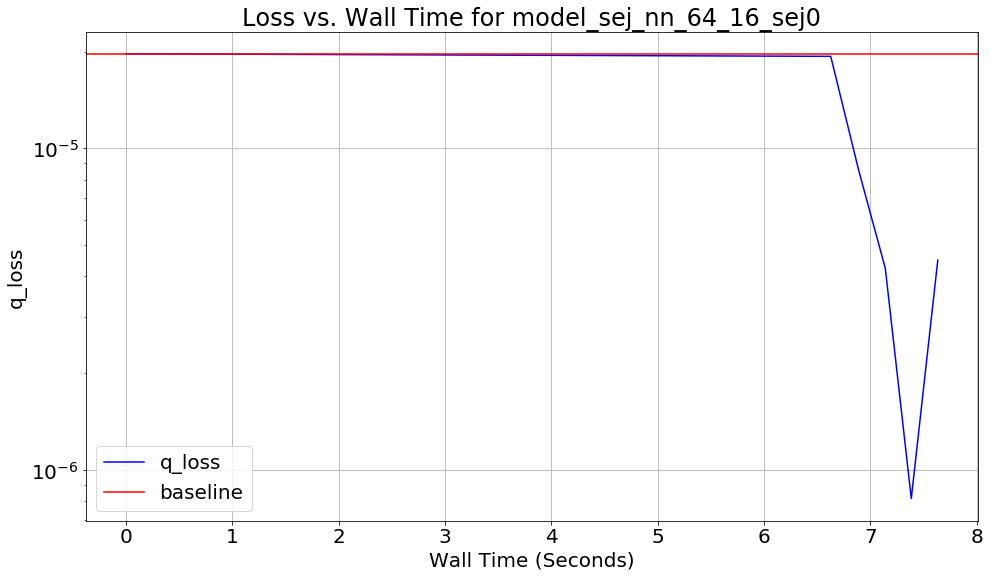

In [37]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Tiny Data Set

In [38]:
# Set up training - tiny data set
model_name = f'model_{model_code}_nn_{suffix}_tiny'

# Number of training epochs
num_batches = 1
epochs_per_batch = 10

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'model_nn.name = {model_nn.name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

model_nn.name = model_g3b_nn_64_16
model_h5 = ../models/sej/model_sej_nn_64_16_tiny.h5
hist_name = hist_sej_nn_64_16_tiny


In [39]:
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_tiny, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16_tiny from ../models/sej/model_sej_nn_64_16_tiny.h5. Fitting...
*** Training batch   1 *** 2019-08-23 09:18:07
Epoch 1/10

Epoch 0001; loss 1.25e-05; elapsed 0:00:00
1/1 [==============================] - 0s 223ms/step - loss: 1.2546e-05 - q_loss: 4.1850e-06 - v_loss: 4.2767e-06 - a_loss: 4.0424e-06 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 1.1973e-08 - P_loss: 3.9447e-14 - L_loss: 2.9548e-08
Epoch 2/10

Epoch 0002; loss 1.30e-05; elapsed 0:00:00
1/1 [==============================] - 0s 176ms/step - loss: 1.3035e-05 - q_loss: 4.6509e-06 - v_loss: 4.6756e-06 - a_loss: 3.6766e-06 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 2.1661e-09 - P_loss: 3.9395e-14 - L_loss: 2.8885e-08
Epoch 3/10

Epoch 0003; loss 1.27e-05; elapsed 0:00:01
1/1 [==============================] - 0s 153ms/step - loss: 1.2750e-05 - q_loss: 4.6772e-06 - v_loss: 4.6638e-06 - a_loss: 3.4051e-06 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_

In [40]:
model_nn.evaluate(ds_tiny)

1/1 [==============================] - 0s 96ms/step - loss: 4.2373e-06 - q_loss: 7.7231e-07 - v_loss: 7.5267e-07 - a_loss: 2.6972e-06 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 8.7658e-10 - P_loss: 3.9373e-14 - L_loss: 1.3723e-08


[4.237305802234914e-06,
 7.72309e-07,
 7.526695e-07,
 2.6971964e-06,
 2.0670675e-14,
 1.9992044e-14,
 8.765811e-10,
 3.9372765e-14,
 1.3722782e-08]

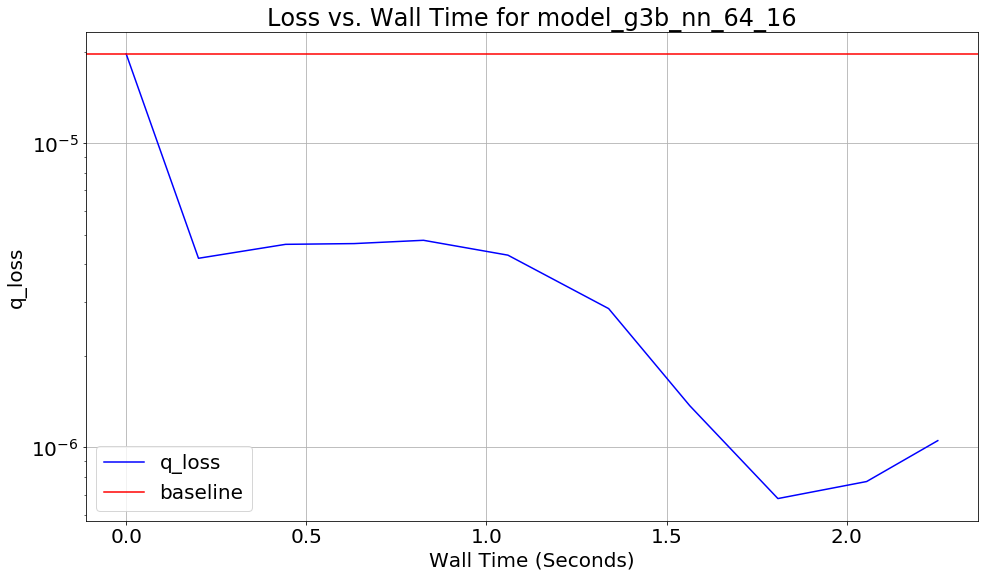

In [41]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 1.0

In [42]:
# Scale factor
scale_factor = 1.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = data_by_factor[scale_factor]

In [43]:
# Evaluate the KJ model on the validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 4s 119ms/step - loss: 6.7764e-05 - q_loss: 1.9676e-05 - v_loss: 1.9652e-05 - a_loss: 2.8436e-05 - q0_rec_loss: 1.5596e-14 - v0_rec_loss: 1.4356e-14 - H_loss: 9.2961e-14 - P_loss: 3.8784e-14 - L_loss: 2.0182e-14


In [44]:
# Set up training - full data, scale factor = 1

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

Training for 1 batches of 5 epochs each.
model_name = model_sej_nn_64_16_sf_1
model_h5 = ../models/sej/model_sej_nn_64_16_sf_1.h5
hist_name = hist_sej_nn_64_16_sf_1


In [45]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16_sf_1 from ../models/sej/model_sej_nn_64_16_sf_1.h5. Fitting...
*** Training batch   1 *** 2019-08-23 09:18:16
Epoch 1/5
194/195 [============================>.] - ETA: 0s - loss: 1.5553e-06 - q_loss: 2.2232e-07 - v_loss: 2.0404e-07 - a_loss: 1.1274e-06 - q0_rec_loss: 1.5368e-14 - v0_rec_loss: 1.4172e-14 - H_loss: 1.6562e-11 - P_loss: 3.9266e-14 - L_loss: 1.0457e-09
Epoch 0001; loss 1.55e-06; elapsed 0:00:51
195/195 [==============================] - 42s 213ms/step - loss: 1.5545e-06 - q_loss: 2.2228e-07 - v_loss: 2.0400e-07 - a_loss: 1.1267e-06 - q0_rec_loss: 1.5370e-14 - v0_rec_loss: 1.4169e-14 - H_loss: 1.6477e-11 - P_loss: 3.9266e-14 - L_loss: 1.0404e-09
Epoch 2/5
194/195 [============================>.] - ETA: 0s - loss: 1.3400e-06 - q_loss: 1.8058e-07 - v_loss: 1.6287e-07 - a_loss: 9.9607e-07 - q0_rec_loss: 1.5368e-14 - v0_rec_loss: 1.4172e-14 - H_loss: 1.0038e-13 - P_loss: 3.9260e-14 - L_loss: 8.9980e-13
Epoch 0002; loss 1.34e-06; elapsed 0:01:41

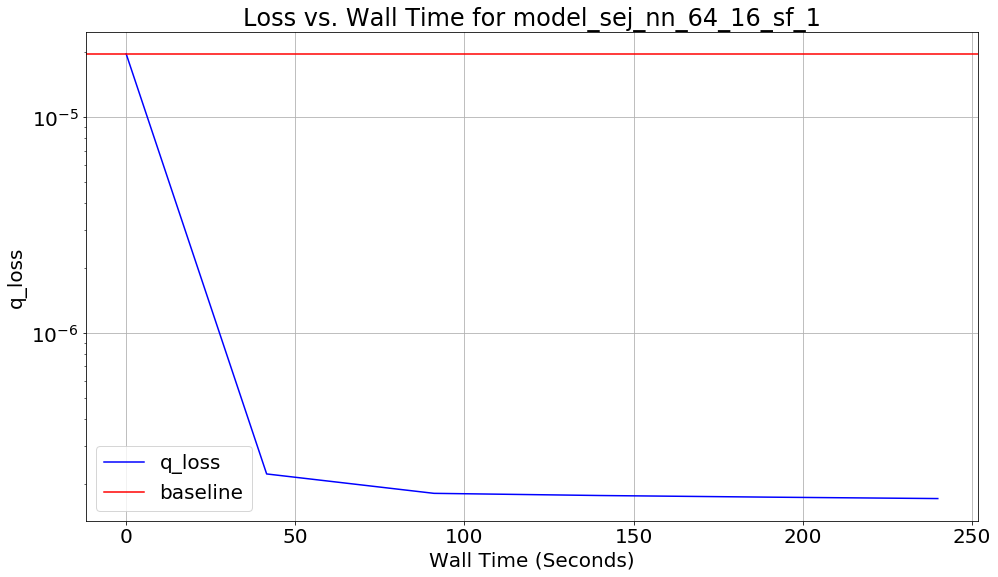

In [46]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

In [47]:
# Plot the total loss
# fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='loss')

In [48]:
# Evaluate the trained model on the training data
# model_nn.evaluate(ds_trn)

In [49]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 4s 128ms/step - loss: 1.2449e-06 - q_loss: 1.5281e-07 - v_loss: 1.3971e-07 - a_loss: 9.5163e-07 - q0_rec_loss: 1.5596e-14 - v0_rec_loss: 1.4356e-14 - H_loss: 1.0152e-13 - P_loss: 3.9335e-14 - L_loss: 1.0712e-10


[1.2448757940676712e-06,
 1.528081e-07,
 1.3970813e-07,
 9.5163404e-07,
 1.559638e-14,
 1.4356488e-14,
 1.01519975e-13,
 3.9334682e-14,
 1.0711654e-10]

In [50]:
# Evaluate the trained model on the test data
# model_nn.evaluate(ds_tst)

### Describe Covariance of Dataset Orbital Elements

In [51]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [52]:
# List of orbital elements in the cov matrix
elt_names = ['a1', 'a2', 'e1', 'e2', 'inc1', 'inc2', 'Omega1', 'Omega2', 'omega1', 'omega2', 'f1', 'f2']
# limit to the interesting ones
elt_names = elt_names[0:6]

In [53]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

SD of a1     = 0.020791
SD of a2     = 0.110142
SD of e1     = 0.009033
SD of e2     = 0.010346
SD of inc1   = 0.006084
SD of inc2   = 0.008534


### Train on Full Data Set with Perturbation Scale Factor = 2.0

In [54]:
# Build combined SEJ data sets with scale factor = 2
scale_factor = 2.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/2569572219.pickle.


Loaded data from ../data/sej/3597212092.pickle.
Loaded data from ../data/sej/1674012657.pickle.
Loaded data from ../data/sej/3016210063.pickle.
Loaded data from ../data/sej/3467657930.pickle.



In [55]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [56]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [57]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

SD of a1     = 0.041659
SD of a2     = 0.220513
SD of e1     = 0.015236
SD of e2     = 0.019587
SD of inc1   = 0.012167
SD of inc2   = 0.014576


In [58]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 4s 124ms/step - loss: 6.7938e-05 - q_loss: 2.0025e-05 - v_loss: 1.9968e-05 - a_loss: 2.7945e-05 - q0_rec_loss: 1.7878e-14 - v0_rec_loss: 1.6894e-14 - H_loss: 9.5447e-14 - P_loss: 3.8691e-14 - L_loss: 2.0115e-14


In [59]:
# Set up training - full data, scale factor = 2

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

Training for 1 batches of 5 epochs each.
model_name = model_sej_nn_64_16_sf_2
model_h5 = ../models/sej/model_sej_nn_64_16_sf_2.h5
hist_name = hist_sej_nn_64_16_sf_2


In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16_sf_2 from ../models/sej/model_sej_nn_64_16_sf_2.h5. Fitting...
*** Training batch   1 *** 2019-08-23 09:23:43
Epoch 1/5
 78/195 [===========>..................] - ETA: 26s - loss: 1.5148e-06 - q_loss: 3.0190e-07 - v_loss: 2.7069e-07 - a_loss: 9.4147e-07 - q0_rec_loss: 1.7794e-14 - v0_rec_loss: 1.6510e-14 - H_loss: 1.0722e-13 - P_loss: 3.9292e-14 - L_loss: 1.2481e-11

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 4.0

In [ ]:
# Build combined SEJ data sets with scale factor = 4
scale_factor = 4.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

In [ ]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [ ]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [ ]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

In [ ]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)

In [ ]:
# Set up training - full data, scale factor = 4

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 8.0

In [ ]:
# Build combined SEJ data sets with scale factor = 8
scale_factor = 8.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

In [ ]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [ ]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [ ]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

In [ ]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

In [ ]:
model_nn.evaluate(ds_val)

In [ ]:
# Set up training - full data, scale factor = 8

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 16.0

In [ ]:
# Build combined SEJ data sets with scale factor = 16
scale_factor = 16.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

In [ ]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [ ]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [ ]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

In [ ]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

In [ ]:
# Set up training - full data, scale factor = 16

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 32.0

In [ ]:
# Build combined SEJ data sets with scale factor = 32
scale_factor = 32.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

In [ ]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [ ]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [ ]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

In [ ]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

In [ ]:
# Set up training - full data, scale factor = 2

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 64.0

### Train on Full Data Set with Perturbation Scale Factor = 128.0

### Train on Full Data Set with Perturbation Scale Factor = 256.0